# Polynomial Transformer Testing Suite

This notebook tests various components of the Polynomial Transformer implementation.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import sys
sys.path.append('/home/ashishkangen/Projects/polyformer')

from former import (
    TransformerBlock, 
    PolyTransformerBlock,
    GTransformer,
    PolyGTransformer,
    CTransformer,
    PolyCTransformer
)

from former.util import (
    CP, CP_sparse_LU, CP_sparse_degree, CP_sparse_degree_LU
)

from former.util import *
from former.util.poly_utils import *

## Utility Functions for Testing

In [2]:
def test_layer(layer, input_shape, verbose=True):
    """Test if a layer can process input and produce output without errors."""
    with torch.no_grad():  # No need for gradient tracking during testing
        x = torch.randn(input_shape)
        try:
            out = layer(x)
            if verbose:
                print(f"✅ Layer works! Input shape: {input_shape}, Output shape: {out.shape}")
            return out.shape
        except Exception as e:
            print(f"❌ Layer failed with input shape {input_shape}. Error: {e}")
            return None

def count_parameters(model):
    """Count the total number of trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def parameter_comparison(model1, model2, names=['Model 1', 'Model 2']):
    """Compare parameter counts between two models."""
    params1 = non_zero_count(model1)
    params2 = non_zero_count(model2)
    
    print(f"{names[0]} parameters: {params1:,}")
    print(f"{names[1]} parameters: {params2:,}")
    
    if params1 > params2:
        print(f"{names[0]} has {params1-params2:,} more parameters ({params1/params2:.3f}x)")
    else:
        print(f"{names[1]} has {params2-params1:,} more parameters ({params2/params1:.3f}x)")

## 1. Testing the PolyTransformerBlock

In [3]:
# Configuration parameters
emb = 64          # Embedding dimension
heads = 4         # Number of attention heads
seq_length = 32   # Sequence length
batch_size = 8    # Batch size

# Create a standard transformer block
transformer_block = TransformerBlock(
    emb=emb,
    heads=heads,
    mask=True, 
    seq_length=seq_length
)

# Create a polynomial transformer block
poly_block = PolyTransformerBlock(
    emb=emb,
    heads=heads,
    mask=True, 
    seq_length=seq_length,
    degree=2,
    poly_class=CP_sparse_degree_LU,
    use_relu=True,
    ff_hidden_mult=2,
    attention_type='sparse_inplace'
)

# Test both blocks with the same input
input_shape = (batch_size, seq_length, emb)
print("Testing standard TransformerBlock:")

with torch.no_grad():  # No need for gradient tracking during testing
    x = torch.randn(input_shape)
    out = poly_block(x)

std_output_shape = test_layer(transformer_block, input_shape)

print("\nTesting PolyTransformerBlock:")
poly_output_shape = test_layer(poly_block, input_shape)

# Verify that both blocks produce the same output shape
if std_output_shape == poly_output_shape:
    print("\n✅ Both blocks produce outputs of the same shape!")
else:
    print(f"\n❌ Output shapes differ! Standard: {std_output_shape}, Poly: {poly_output_shape}")

# Compare parameter counts
print("\nParameter comparison:")
parameter_comparison(transformer_block, poly_block, ["Standard TransformerBlock", "PolyTransformerBlock"])

Testing standard TransformerBlock:
✅ Layer works! Input shape: (8, 32, 64), Output shape: torch.Size([8, 32, 64])

Testing PolyTransformerBlock:
✅ Layer works! Input shape: (8, 32, 64), Output shape: torch.Size([8, 32, 64])

✅ Both blocks produce outputs of the same shape!

Parameter comparison:
Standard TransformerBlock parameters: 49,664
PolyTransformerBlock parameters: 27,072
Standard TransformerBlock has 22,592 more parameters (1.000x)


## 2. Testing Different Polynomial Classes

In [4]:
# Test various polynomial network implementations
poly_classes = [CP, CP_sparse_LU, CP_sparse_degree, CP_sparse_degree_LU]
poly_class_names = ['CP', 'CP_sparse_LU', 'CP_sparse_degree', 'CP_sparse_degree_LU']

# Test with different degrees
degrees = [1, 2, 3]

results = {}

for degree in degrees:
    print(f"\n\nTesting with degree = {degree}:")
    
    for cls, name in zip(poly_classes, poly_class_names):
        print(f"\nTesting {name}:")
        
        try:
            block = PolyTransformerBlock(
                emb=emb,
                heads=heads,
                mask=True, 
                seq_length=seq_length,
                degree=degree,
                poly_class=cls
            )
            
            _ = test_layer(block, input_shape, verbose=False)
            param_count = non_zero_count(block)
            results[(degree, name)] = param_count
            
            print(f"✅ {name} with degree {degree} works! Parameters: {param_count:,}")
            
        except Exception as e:
            print(f"❌ {name} with degree {degree} failed. Error: {e}")
            results[(degree, name)] = None

# Print summary table
print("\n\nSummary of parameter counts:")
print("-" * 60)
print(f"{'Degree':<10} {'Class':<20} {'Parameters':<15}")
print("-" * 60)

for (degree, cls_name), params in sorted(results.items()):
    if params is not None:
        print(f"{degree:<10} {cls_name:<20} {params:,}")
    else:
        print(f"{degree:<10} {cls_name:<20} {'Failed'}")



Testing with degree = 1:

Testing CP:
✅ CP with degree 1 works! Parameters: 49,408

Testing CP_sparse_LU:
✅ CP_sparse_LU with degree 1 works! Parameters: 47,392

Testing CP_sparse_degree:
✅ CP_sparse_degree with degree 1 works! Parameters: 49,408

Testing CP_sparse_degree_LU:
✅ CP_sparse_degree_LU with degree 1 works! Parameters: 47,392


Testing with degree = 2:

Testing CP:
✅ CP with degree 2 works! Parameters: 41,216

Testing CP_sparse_LU:
✅ CP_sparse_LU with degree 2 works! Parameters: 33,088

Testing CP_sparse_degree:
✅ CP_sparse_degree with degree 2 works! Parameters: 37,120

Testing CP_sparse_degree_LU:
✅ CP_sparse_degree_LU with degree 2 works! Parameters: 32,032


Testing with degree = 3:

Testing CP:
✅ CP with degree 3 works! Parameters: 38,400

Testing CP_sparse_LU:
✅ CP_sparse_LU with degree 3 works! Parameters: 31,008

Testing CP_sparse_degree:
✅ CP_sparse_degree with degree 3 works! Parameters: 32,896

Testing CP_sparse_degree_LU:
✅ CP_sparse_degree_LU with degree 3 wor

## 3. Testing Full Transformer Models

In [5]:
# Configuration for full transformer models
emb = 128  # Embedding dimension
heads = 8  # Number of attention heads
depth = 3  # Number of transformer blocks
seq_length = 64  # Sequence length
num_tokens = 10000  # Vocabulary size
num_classes = 5  # For classification model

print("1. Testing generative models (GTransformer vs PolyGTransformer):")
g_transformer = GTransformer(emb, heads, depth, seq_length, num_tokens)
poly_g_transformer = PolyGTransformer(emb, heads, depth, seq_length, num_tokens, degree=2, ff_hidden_mult=2, poly_class=CP_sparse_degree_LU, attention_type='sparse_inplace')

# Test with a batch of token indices
token_indices = torch.randint(0, num_tokens, (4, seq_length))

with torch.no_grad():
    g_out = g_transformer(token_indices)
    poly_g_out = poly_g_transformer(token_indices)
    
    print(f"GTransformer output shape: {g_out.shape}")
    print(f"PolyGTransformer output shape: {poly_g_out.shape}")
    
    if g_out.shape == poly_g_out.shape:
        print("✅ Both generative models produce the same output shape!")
    else:
        print("❌ Generative models produce different output shapes!")

print("\nParameter comparison:")
parameter_comparison(g_transformer, poly_g_transformer, ["GTransformer", "PolyGTransformer"])

print("\n2. Testing classification models (CTransformer vs PolyCTransformer):")
c_transformer = CTransformer(emb, heads, depth, seq_length, num_tokens, num_classes)
poly_c_transformer = PolyCTransformer(emb, heads, depth, seq_length, num_tokens, num_classes, degree=2)

with torch.no_grad():
    c_out = c_transformer(token_indices)
    poly_c_out = poly_c_transformer(token_indices)
    
    print(f"CTransformer output shape: {c_out.shape}")
    print(f"PolyCTransformer output shape: {poly_c_out.shape}")
    
    if c_out.shape == poly_c_out.shape:
        print("✅ Both classification models produce the same output shape!")
    else:
        print("❌ Classification models produce different output shapes!")

print("\nParameter comparison:")
parameter_comparison(c_transformer, poly_c_transformer, ["CTransformer", "PolyCTransformer"])

1. Testing generative models (GTransformer vs PolyGTransformer):


GTransformer output shape: torch.Size([4, 64, 10000])
PolyGTransformer output shape: torch.Size([4, 64, 10000])
✅ Both generative models produce the same output shape!

Parameter comparison:
GTransformer parameters: 3,171,088
PolyGTransformer parameters: 2,813,776
GTransformer has 357,312 more parameters (1.000x)

2. Testing classification models (CTransformer vs PolyCTransformer):
CTransformer output shape: torch.Size([4, 5])
PolyCTransformer output shape: torch.Size([4, 5])
✅ Both classification models produce the same output shape!

Parameter comparison:
CTransformer parameters: 1,881,733
PolyCTransformer parameters: 1,781,892
CTransformer has 99,841 more parameters (1.000x)


## 4. Testing Different Attention Types with Polynomial Networks

In [6]:
attention_types = [
    'default', 'sparse_inplace', 'sparse_graph'
]

for att_type in attention_types:
    print(f"\nTesting PolyTransformerBlock with attention_type='{att_type}'")
    
    try:
        # Some attention types might need special handling
        kwargs = {}
        if att_type == 'relative':
            # Relative attention needs position embeddings
            pos_emb = nn.Embedding(seq_length * 2 - 1, emb)
            kwargs['pos_embedding'] = pos_emb
            
        block = PolyTransformerBlock(
            emb=emb,
            heads=heads,
            mask=True, 
            seq_length=seq_length,
            degree=2,
            attention_type=att_type,
            **kwargs
        )
        
        out_shape = test_layer(block, input_shape)
        if out_shape is not None:
            print(f"  ✅ PolyTransformerBlock with {att_type} attention works!")
        
    except Exception as e:
        print(f"  ❌ PolyTransformerBlock with {att_type} attention failed. Error: {e}")


Testing PolyTransformerBlock with attention_type='default'
❌ Layer failed with input shape (8, 32, 64). Error: Input embedding dim (64) should match layer embedding dim (128)

Testing PolyTransformerBlock with attention_type='sparse_inplace'
❌ Layer failed with input shape (8, 32, 64). Error: Input embedding dim (64) should match layer embedding dim (128)

Testing PolyTransformerBlock with attention_type='sparse_graph'
❌ Layer failed with input shape (8, 32, 64). Error: Input embedding dim (64) should match layer embedding dim (128)


## 5. Test Training with Small Synthetic Task

Training GTransformer:
Epoch 1, Loss: 4.7203
Epoch 2, Loss: 4.5752
Epoch 3, Loss: 4.3721
Epoch 4, Loss: 4.1934
Epoch 5, Loss: 3.9957
Epoch 6, Loss: 3.8013
Epoch 7, Loss: 3.6031
Epoch 8, Loss: 3.4423
Epoch 9, Loss: 3.2391
Epoch 10, Loss: 3.0430

Training PolyGTransformer:
Epoch 1, Loss: 4.7011
Epoch 2, Loss: 4.4956
Epoch 3, Loss: 4.3190
Epoch 4, Loss: 4.1483
Epoch 5, Loss: 3.9626
Epoch 6, Loss: 3.8019
Epoch 7, Loss: 3.6088
Epoch 8, Loss: 3.4077
Epoch 9, Loss: 3.2364
Epoch 10, Loss: 3.0699


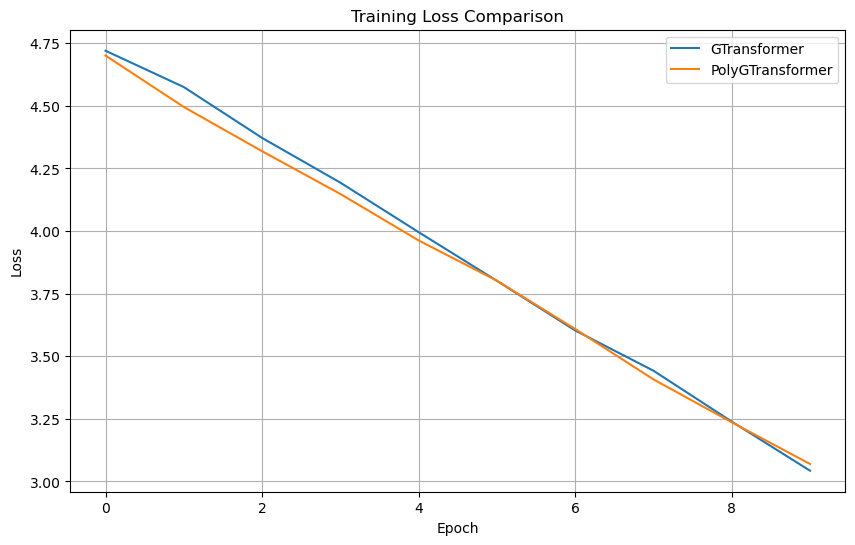

tensor(32228)
tensor(23300)


In [32]:
import torch.optim as optim

def train_for_epochs(model, epochs=5, batch_size=32, seq_len=16, vocab_size=100):
    """Train a model for a few epochs on a simple synthetic sequence task."""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Simple synthetic task: predict next token in a sequence
    losses = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        
        # Generate synthetic data - sequences where each token is the previous token + 1
        for i in range(5):
            # Generate random starting point for sequences
            starts = torch.randint(0, vocab_size - seq_len, (batch_size, 1))
            # Create sequences with a pattern (each position is previous + 1)
            seqs = torch.cat([starts + j for j in range(seq_len)], dim=1)
            
            # Inputs are all but last token, targets are all but first token
            inputs = seqs[:, :-1]
            targets = seqs[:, 1:].contiguous().view(-1)
            
            # Forward pass
            outputs = model(inputs)
            
            # Reshape for loss calculation
            outputs = outputs.view(-1, vocab_size)
            
            # Calculate loss
            loss = criterion(outputs, targets)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_loss = running_loss / 5
        losses.append(avg_loss)
        print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')
    
    return losses

# Setup simplified models for training test
vocab_size = 100
seq_len = 16
emb = 32
heads = 2
depth = 2
epochs = 10

print("Training GTransformer:")
g_model = GTransformer(emb, heads, depth, seq_len, vocab_size)
g_losses = train_for_epochs(g_model, epochs=epochs, vocab_size=vocab_size, seq_len=seq_len)

print("\nTraining PolyGTransformer:")
poly_g_model = PolyGTransformer(emb, heads, depth, seq_len, vocab_size, degree=2, ff_hidden_mult=4, poly_class=CP_sparse_degree_LU, use_relu=False)
poly_g_losses = train_for_epochs(poly_g_model, epochs=epochs, vocab_size=vocab_size, seq_len=seq_len)

# Plot loss comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(g_losses, label='GTransformer')
plt.plot(poly_g_losses, label='PolyGTransformer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True)
plt.show()

print(non_zero_count(g_model))
print(non_zero_count(poly_g_model))

## 6. Test Inference Speed Comparison

In [8]:
import time

def measure_inference_time(model, input_tensor, runs=10):
    """Measure average inference time over multiple runs."""
    # Warm-up run
    with torch.no_grad():
        _ = model(input_tensor)
    
    # Timed runs
    start_time = time.time()
    
    with torch.no_grad():
        for _ in range(runs):
            _ = model(input_tensor)
            
    end_time = time.time()
    avg_time = (end_time - start_time) / runs
    
    return avg_time

# Setup models for speed comparison
emb = 256
heads = 8
depth = 4
seq_length = 64
vocab_size = 10000
batch_size = 16

# Create input tensor for inference
input_tensor = torch.randint(0, vocab_size, (batch_size, seq_length))

# Create models for comparison
models = {
    "GTransformer": GTransformer(emb, heads, depth, seq_length, vocab_size),
    "PolyGTransformer (degree=1)": PolyGTransformer(emb, heads, depth, seq_length, vocab_size, degree=1, ff_hidden_mult=2),
    "PolyGTransformer (degree=2)": PolyGTransformer(emb, heads, depth, seq_length, vocab_size, degree=2, ff_hidden_mult=2, poly_class=CP_sparse_degree_LU),
    "PolyGTransformer (degree=3)": PolyGTransformer(emb, heads, depth, seq_length, vocab_size, degree=3, ff_hidden_mult=2),
    "PolyGTransformer (CP_sparse_LU)": PolyGTransformer(emb, heads, depth, seq_length, vocab_size, degree=2, poly_class=CP_sparse_LU, ff_hidden_mult=2)
}

# Run timing tests
times = {}
for name, model in models.items():
    print(f"Measuring inference time for {name}...")
    times[name] = measure_inference_time(model, input_tensor)

# Print results
print("\nInference Speed Comparison:")
print("-" * 70)
print(f"{'Model':<30} {'Time (ms)':<10} {'Relative Speed':<15}")
print("-" * 70)

# Use standard transformer as baseline
baseline = times["GTransformer"]
for name, time_taken in times.items():
    rel_speed = baseline / time_taken
    print(f"{name:<30} {time_taken*1000:>9.2f} {rel_speed:>14.2f}x")

Measuring inference time for GTransformer...
Measuring inference time for PolyGTransformer (degree=1)...
Measuring inference time for PolyGTransformer (degree=2)...
Measuring inference time for PolyGTransformer (degree=3)...
Measuring inference time for PolyGTransformer (CP_sparse_LU)...

Inference Speed Comparison:
----------------------------------------------------------------------
Model                          Time (ms)  Relative Speed 
----------------------------------------------------------------------
GTransformer                      443.87           1.00x
PolyGTransformer (degree=1)       375.05           1.18x
PolyGTransformer (degree=2)       459.13           0.97x
PolyGTransformer (degree=3)       484.57           0.92x
PolyGTransformer (CP_sparse_LU)    392.93           1.13x


In [33]:
g_model

GTransformer(
  (token_embedding): Embedding(100, 32)
  (pos_embedding): Embedding(16, 32)
  (tblocks): Sequential(
    (0): TransformerBlock(
      (attention): SelfAttention(
        (tokeys): Linear(in_features=32, out_features=32, bias=False)
        (toqueries): Linear(in_features=32, out_features=32, bias=False)
        (tovalues): Linear(in_features=32, out_features=32, bias=False)
        (unifyheads): Linear(in_features=32, out_features=32, bias=True)
      )
      (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (ff): Sequential(
        (0): Linear(in_features=32, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=32, bias=True)
      )
      (do): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (attention): SelfAttention(
        (tokeys): Linear(in_features=32, out_features=32, bias=False)
        (toqueries): Linear(in